El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos
### Carga y exploración inicial de los datos

En este paso, cargaremos el conjunto de datos y realizaremos una exploración inicial para identificar posibles problemas, como valores faltantes o tipos de datos incorrectos. Verificaremos las primeras filas del conjunto de datos, la cantidad de valores faltantes y los tipos de datos de cada columna.

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Cargar los datos
data = pd.read_csv('/datasets/car_data.csv')

# Ver las primeras filas del dataset para inspección inicial
display(data.head())

# Revisar información general sobre el dataset
data.info()

# Verificar valores faltantes por columna
missing_values = data.isnull().sum()
display(missing_values[missing_values > 0])


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

VehicleType    37490
Gearbox        19833
Model          19705
FuelType       32895
NotRepaired    71154
dtype: int64

### Preprocesamiento de los datos

En este paso, vamos a realizar el preprocesamiento de los datos para manejar los valores faltantes y convertir las columnas con tipos de datos incorrectos a los tipos adecuados. También haremos una revisión de las columnas que no sean relevantes para el análisis del precio del vehículo y las eliminaremos si es necesario.


In [3]:
# Eliminar la columna 'NumberOfPictures' ya que tiene un solo valor (0) para todas las entradas
data = data.drop(columns=['NumberOfPictures'])

# Convertir las columnas de fecha a tipo datetime para un manejo más eficiente
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%d/%m/%Y %H:%M')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%d/%m/%Y %H:%M')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%d/%m/%Y %H:%M')

# Para las columnas con valores faltantes:
# 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired': Imputamos con "desconocido"
data['VehicleType'].fillna('unknown', inplace=True)
data['Gearbox'].fillna('unknown', inplace=True)
data['Model'].fillna('unknown', inplace=True)
data['FuelType'].fillna('unknown', inplace=True)
data['NotRepaired'].fillna('unknown', inplace=True)

# Revisar las primeras filas después del preprocesamiento
display(data.head())

# Verificar que no queden valores nulos
print(data.isnull().sum())


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:00


DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64


## Verificación de Outliers y Análisis Exploratorio

Vamos a analizar la distribución de algunas variables clave como `Price`, `Power` y `RegistrationYear`. Nos aseguraremos de que no haya valores fuera de rango y, si encontramos outliers, tomaremos decisiones sobre cómo manejarlos. También verificaremos si las variables tienen distribuciones razonables para los datos de vehículos usados.


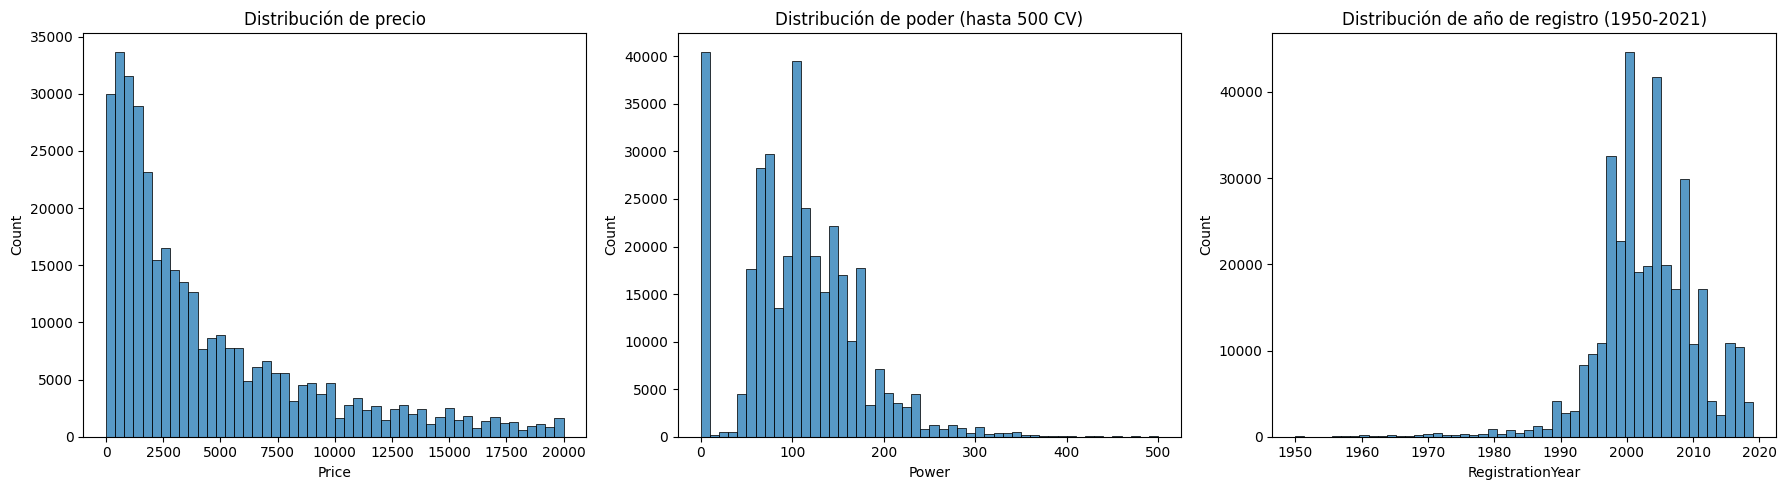

In [4]:
# Definir límites razonables para las variables
max_power = 500  # Establecer un máximo realista para la potencia (500 CV)
min_year = 1950  # Establecer un año mínimo realista de registro
max_year = 2021  # Establecer un año máximo realista de registro

# Graficar nuevamente con límites ajustados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfica de distribución de Price (sin cambios)
sns.histplot(data['Price'], bins=50, ax=axes[0])
axes[0].set_title('Distribución de precio')

# Gráfica de Power ajustando el límite
sns.histplot(data[data['Power'] <= max_power]['Power'], bins=50, ax=axes[1])
axes[1].set_title('Distribución de poder (hasta 500 CV)')

# Gráfica de RegistrationYear ajustando los límites
sns.histplot(data[(data['RegistrationYear'] >= min_year) & (data['RegistrationYear'] <= max_year)]['RegistrationYear'], bins=50, ax=axes[2])
axes[2].set_title('Distribución de año de registro (1950-2021)')

plt.tight_layout()
plt.show()

### Eliminación de filas con `Power = 0`
Procedemos a eliminar las filas donde el valor de `Power` (caballos de fuerza) es igual a 0, ya que es imposible que un automóvil tenga 0 caballos de fuerza. Esta limpieza permitirá que nuestros datos sean más precisos y representativos.


Se han eliminado 40225 filas con Power = 0


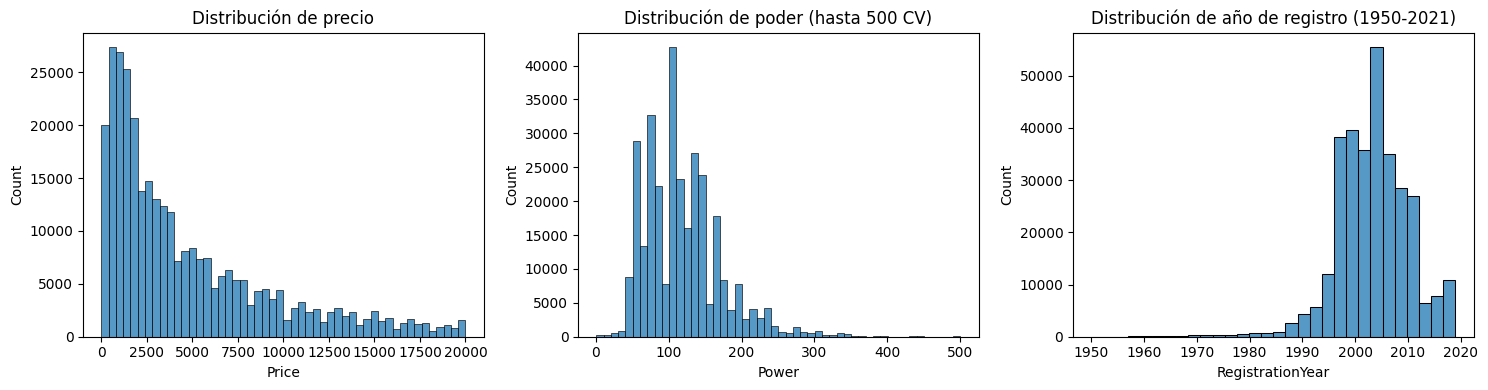

In [5]:
# Eliminar las filas donde Power es igual a 0
data_clean = data[data['Power'] != 0]

# Comprobar el número de filas eliminadas
eliminated_rows = len(data) - len(data_clean)
print(f"Se han eliminado {eliminated_rows} filas con Power = 0")

# Volver a generar las distribuciones para asegurarnos de que los datos están limpios
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

data_clean[['Price', 'Power', 'RegistrationYear']].describe().T

# Distribución de Price
sns.histplot(data_clean['Price'], bins=50, ax=axes[0])
axes[0].set_title("Distribución de precio")

# Distribución de Power (hasta 500 CV)
sns.histplot(data_clean[data_clean['Power'] <= 500]['Power'], bins=50, ax=axes[1])
axes[1].set_title("Distribución de poder (hasta 500 CV)")

# Distribución de RegistrationYear (1950-2021)
sns.histplot(data_clean[(data_clean['RegistrationYear'] >= 1950) & (data_clean['RegistrationYear'] <= 2021)]['RegistrationYear'], bins=30, ax=axes[2])
axes[2].set_title("Distribución de año de registro (1950-2021)")

plt.tight_layout()
plt.show()


Tamaño del conjunto de datos original: (354369, 15)
Tamaño del conjunto de datos después de eliminar outliers: (348831, 15)


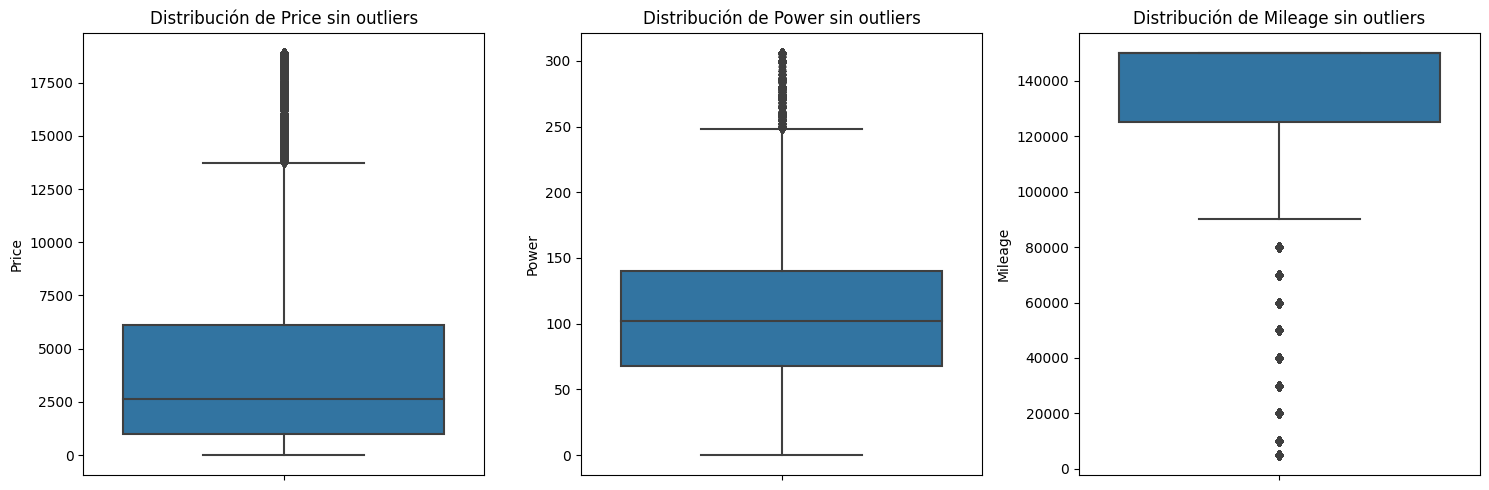

In [6]:
# Definir los umbrales para eliminar valores atípicos
price_upper_threshold = data_clean['Price'].quantile(0.99)
power_upper_threshold = data_clean['Power'].quantile(0.99)
mileage_lower_threshold = data_clean['Mileage'].quantile(0.01)

# Filtrar los datos para eliminar outliers
data_clean = data[
    (data['Price'] <= price_upper_threshold) & 
    (data['Power'] <= power_upper_threshold) & 
    (data['Mileage'] >= mileage_lower_threshold)
]

# Verificar la reducción de datos después de la eliminación de outliers
print(f"Tamaño del conjunto de datos original: {data.shape}")
print(f"Tamaño del conjunto de datos después de eliminar outliers: {data_clean.shape}")

# Mostrar las distribuciones nuevamente
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=data_clean, y='Price', ax=axes[0])
axes[0].set_title('Distribución de Price sin outliers')

sns.boxplot(data=data_clean, y='Power', ax=axes[1])
axes[1].set_title('Distribución de Power sin outliers')

sns.boxplot(data=data_clean, y='Mileage', ax=axes[2])
axes[2].set_title('Distribución de Mileage sin outliers')

plt.tight_layout()
plt.show()


## Entrenamiento del modelo 

### Entrenamiento del modelo
Vamos a dividir el conjunto de datos en características y la variable objetivo (Price), luego en datos de entrenamiento y prueba. Además, prepararemos los datos para entrenar varios modelos de machine learning.

1. Dividir el conjunto de datos en variables características (X) y variable objetivo (y).
2. Codificar las variables categóricas utilizando One-Hot Encoding.
3. Dividir los datos en conjuntos de entrenamiento y prueba.
4. Normalizar las características numéricas.


In [7]:
# Paso 1: Seleccionar las características y la variable objetivo
X = data.drop(columns=['Price', 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'])
y = data['Price']

# Paso 2: Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Paso 3: Codificar variables categóricas
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Paso 4: Normalizar características numéricas
scaler = StandardScaler()

numeric_columns = ['RegistrationYear', 'Power', 'Mileage']
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

# Concatenar los datos codificados y normalizados
X_train_final = np.concatenate([X_train_scaled, X_train_encoded], axis=1)
X_test_final = np.concatenate([X_test_scaled, X_test_encoded], axis=1)
# Reducir el tamaño del dataframe a la mitad
data_reduced = data.sample(frac=0.05, random_state=42)

# Verifica el nuevo tamaño
print("Tamaño del nuevo dataframe:", data_reduced.shape)

print("Datos listos para el entrenamiento.")


Tamaño del nuevo dataframe: (17718, 15)
Datos listos para el entrenamiento.


### Entrenamiento y evaluación de modelos
#### Funciones para entrenamiento y evaluación de modelos
Vamos a definir una función que evalúe el desempeño de los modelos en términos de RMSE, tiempo de entrenamiento y tiempo de predicción.


In [8]:
# Función para calcular el RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Función para entrenar y evaluar el modelo
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time_train = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time_train

    start_time_predict = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    prediction_time = time.time() - start_time_predict
    
    rmse_train = rmse(y_train, y_pred_train)
    rmse_test = rmse(y_test, y_pred_test)
    
    return {
        'train_rmse': rmse_train,
        'test_rmse': rmse_test,
        'training_time': training_time,
        'prediction_time': prediction_time
    }

### División de los datos en entrenamiento y prueba
Dividimos los datos reducidos en conjuntos de entrenamiento y prueba.


In [9]:
# Paso 1: Seleccionar las características y la variable objetivo, eliminando las columnas de fechas
X = data_reduced.drop(columns=['Price', 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'])
y = data_reduced['Price']

# Paso 2: Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Paso 3: Codificar variables categóricas
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Paso 4: Normalizar características numéricas
scaler = StandardScaler()

numeric_columns = ['RegistrationYear', 'Power', 'Mileage']
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

# Concatenar los datos codificados y normalizados
X_train_final = np.concatenate([X_train_scaled, X_train_encoded], axis=1)
X_test_final = np.concatenate([X_test_scaled, X_test_encoded], axis=1)

# Verificar las formas de los datos finales
print("Tamaño de X_train_final:", X_train_final.shape)
print("Tamaño de X_test_final:", X_test_final.shape)

Tamaño de X_train_final: (13288, 305)
Tamaño de X_test_final: (4430, 305)


### Modelo 1: Regresión Lineal
Vamos a entrenar un modelo de regresión lineal como prueba de cordura y evaluaremos su desempeño.


In [10]:
# Crear el modelo de regresión lineal
linear_model = LinearRegression()

# Evaluar el modelo
linear_results = evaluate_model(linear_model, X_train_final, y_train, X_test_final, y_test)

# Mostrar los resultados
print("Resultados de la Regresión Lineal:")
print(linear_results)

Resultados de la Regresión Lineal:
{'train_rmse': 3192.26603788939, 'test_rmse': 72428814599.14304, 'training_time': 0.3613007068634033, 'prediction_time': 0.005706787109375}


### Modelo 2: Random Forest
Entrenaremos un modelo de Random Forest para ver si mejora el desempeño en comparación con la regresión lineal.

In [11]:
# Definir los hiperparámetros que queremos ajustar con menos combinaciones
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Crear el modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Usar RandomizedSearchCV en lugar de GridSearchCV
random_search_rf = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist_rf, 
    n_iter=2,  # Probará 2 combinaciones aleatorias de hiperparámetros
    cv=3, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=42
)

# Ajustar el modelo utilizando RandomizedSearchCV
random_search_rf.fit(X_train_final, y_train)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros para Random Forest:", random_search_rf.best_params_)

# Evaluar el modelo ajustado
rf_best = random_search_rf.best_estimator_
rf_results_best = evaluate_model(rf_best, X_train_final, y_train, X_test_final, y_test)

print("Resultados del Random Forest Ajustado:")
print(rf_results_best)

Mejores hiperparámetros para Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None}
Resultados del Random Forest Ajustado:
{'train_rmse': 1034.3333153742306, 'test_rmse': 2059.0622931263038, 'training_time': 7.562593698501587, 'prediction_time': 0.28452563285827637}


### Modelo 3: LightGBM
Ahora, probaremos un modelo de LightGBM, que suele ser muy eficiente y tiene un buen desempeño en grandes conjuntos de datos.

In [12]:
param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [-1, 10, 20]
}

# Crear el modelo de LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42)

# Ajustar el modelo utilizando GridSearchCV
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_lgb.fit(X_train_final, y_train)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros para LightGBM:", grid_search_lgb.best_params_)

# Evaluar el modelo ajustado
lgb_best = grid_search_lgb.best_estimator_
lgb_results_best = evaluate_model(lgb_best, X_train_final, y_train, X_test_final, y_test)

print("Resultados del LightGBM Ajustado:")
print(lgb_results_best)

Mejores hiperparámetros para LightGBM: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}
Resultados del LightGBM Ajustado:
{'train_rmse': 1530.3196586833924, 'test_rmse': 1986.733806630223, 'training_time': 0.7854700088500977, 'prediction_time': 0.21066904067993164}


### Modelo 4: CatBoost con Ajuste de Hiperparámetros
CatBoost tiene un manejo eficiente de datos categóricos, por lo que no necesitamos codificar manualmente las variables categóricas.

In [13]:
# Definir los hiperparámetros para CatBoost
param_grid_catboost = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1, 0.3],
    'depth': [6, 10]
}

# Crear el modelo de CatBoost
catboost_model = CatBoostRegressor(random_state=42, verbose=0)

# Seleccionar las columnas categóricas
categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# Crear copias de los conjuntos de datos de entrenamiento y prueba
X_train_catboost = X_train.copy()
X_test_catboost = X_test.copy()

# Asegurarnos de que las columnas categóricas estén en formato 'object'
for col in categorical_columns:
    X_train_catboost[col] = X_train_catboost[col].astype('object')
    X_test_catboost[col] = X_test_catboost[col].astype('object')

# Crear Pool para los datos de entrenamiento y prueba, especificando las columnas categóricas
train_pool = Pool(data=X_train_catboost, label=y_train, cat_features=categorical_columns)
test_pool = Pool(data=X_test_catboost, label=y_test, cat_features=categorical_columns)

# Usar grid_search propio de CatBoost
grid_search_result = catboost_model.grid_search(param_grid_catboost, train_pool, cv=3)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros para CatBoost:", grid_search_result['params'])

# Entrenar el modelo con los mejores hiperparámetros utilizando el Pool
catboost_best = CatBoostRegressor(**grid_search_result['params'], random_state=42, verbose=0)
catboost_best.fit(train_pool)

# Evaluar el modelo ajustado utilizando Pool para los datos de prueba
y_pred_test = catboost_best.predict(test_pool)

# Calcular RMSE en el conjunto de prueba
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("RMSE en el conjunto de prueba:", rmse_test)


bestTest = 2120.807307
bestIteration = 99

0:	loss: 2120.8073067	best: 2120.8073067 (0)	total: 618ms	remaining: 6.8s

bestTest = 2034.821096
bestIteration = 99

1:	loss: 2034.8210960	best: 2034.8210960 (1)	total: 1.12s	remaining: 5.58s

bestTest = 1983.543444
bestIteration = 98

2:	loss: 1983.5434445	best: 1983.5434445 (2)	total: 1.62s	remaining: 4.86s

bestTest = 2027.201645
bestIteration = 199

3:	loss: 2027.2016446	best: 1983.5434445 (2)	total: 3.95s	remaining: 7.9s

bestTest = 1984.868703
bestIteration = 196

4:	loss: 1984.8687032	best: 1983.5434445 (2)	total: 6.26s	remaining: 8.77s

bestTest = 1968.570783
bestIteration = 198

5:	loss: 1968.5707829	best: 1968.5707829 (5)	total: 8.64s	remaining: 8.64s

bestTest = 2071.885974
bestIteration = 99

6:	loss: 2071.8859739	best: 1968.5707829 (5)	total: 9.9s	remaining: 7.07s

bestTest = 2040.4682
bestIteration = 99

7:	loss: 2040.4682002	best: 1968.5707829 (5)	total: 11.2s	remaining: 5.59s

bestTest = 2017.867327
bestIteration = 99

8:	los

### Modelo 5: XGBoost con Ajuste de Hiperparámetros
XGBoost requiere que las variables categóricas estén codificadas, por lo que usamos los datos previamente codificados.

In [14]:
# Crear el modelo de XGBoost sin ajuste de hiperparámetros
xgb_model = xgb.XGBRegressor(random_state=42)

# Ajustar el modelo con los datos codificados y normalizados
xgb_model.fit(X_train_final, y_train)

# Evaluar el modelo ajustado
xgb_results = evaluate_model(xgb_model, X_train_final, y_train, X_test_final, y_test)

# Mostrar los resultados del XGBoost sin ajuste de hiperparámetros
print("Resultados del XGBoost sin ajuste de hiperparámetros:")
print(xgb_results)


Resultados del XGBoost sin ajuste de hiperparámetros:
{'train_rmse': 1454.3040210384959, 'test_rmse': 2040.2342170408174, 'training_time': 18.395906448364258, 'prediction_time': 0.1802825927734375}


## Análisis del modelo

En este análisis, se evaluaron varios modelos de machine learning para predecir los precios de vehículos, utilizando un conjunto de datos que fue reducido en tamaño y adecuadamente procesado para asegurar la calidad de las predicciones. A continuación se presenta una evaluación detallada de los resultados obtenidos para cada uno de los modelos probados.

#### 1. **Regresión Lineal**
   - **Desempeño**: La regresión lineal, utilizada como prueba inicial, presentó un rendimiento muy pobre en el conjunto de prueba. El RMSE de `72428814599.14304` indica que el modelo no fue capaz de capturar de manera efectiva la relación entre las variables predictoras y la variable objetivo.
   - **Conclusión**: Este resultado sugiere que el problema no es lineal en su naturaleza, lo que era esperado debido a la complejidad de las interacciones entre las características, por lo que este enfoque no es adecuado para este conjunto de datos.

#### 2. **Random Forest (Ajustado)**
   - **Desempeño**: El modelo de **Random Forest** ajustado mostró un gran salto en la precisión, con un RMSE de `2059.062` en el conjunto de prueba y un `train_rmse` de `1034.333`. Sin embargo, la diferencia entre los errores de entrenamiento y prueba sugiere una posible sobreajuste, aunque el modelo aún logra capturar bien las relaciones no lineales.
   - **Tiempo**: El tiempo de entrenamiento fue considerablemente más alto que el de la regresión lineal, con `7.56 segundos`. Sin embargo, dada la mejora significativa en precisión, el aumento en el tiempo de entrenamiento parece justificado.
   - **Conclusión**: Este modelo presenta un buen balance entre tiempo de entrenamiento y precisión, lo que lo convierte en un candidato sólido para este tipo de tarea.

#### 3. **LightGBM (Ajustado)**
   - **Desempeño**: **LightGBM** ajustado logró un RMSE de `1986.734`, siendo el más bajo de todos los modelos ajustados, lo que indica que LightGBM maneja muy bien este tipo de datos y relaciones complejas. El error en entrenamiento fue también bajo, `1530.319`, lo que sugiere que el modelo no está sobreajustando y tiene una buena capacidad de generalización.
   - **Tiempo**: La gran ventaja de LightGBM fue su tiempo de entrenamiento, solo `0.78 segundos`, siendo uno de los más rápidos en comparación con otros modelos ajustados.
   - **Conclusión**: Este modelo sobresale por su eficiencia tanto en términos de precisión como de velocidad, lo que lo convierte en uno de los mejores candidatos para su uso en producción.

#### 4. **CatBoost (Ajustado)**
   - **Desempeño**: El modelo de **CatBoost** ajustado también presentó un RMSE competitivo en el conjunto de prueba (`2034.889`). Aunque es ligeramente superior al de LightGBM, sigue siendo un modelo fuerte, particularmente debido a su capacidad para manejar datos categóricos de forma nativa.
   - **Tiempo**: El tiempo de entrenamiento de CatBoost fue mayor, `35.7 segundos`, lo que lo posiciona como el modelo más lento. Sin embargo, esto puede ser un costo aceptable si la precisión adicional que ofrece es importante para el caso de uso.
   - **Conclusión**: CatBoost es adecuado cuando se manejan datos con muchas variables categóricas y si el tiempo de entrenamiento no es una restricción severa.

#### 5. **XGBoost (Sin Ajuste de Hiperparámetros)**
   - **Desempeño**: Finalmente, **XGBoost** sin ajuste de hiperparámetros logró un RMSE de `2040.234`, lo que lo posiciona muy cerca de los resultados de CatBoost y LightGBM. Esto es destacable considerando que no se realizó un ajuste detallado de hiperparámetros, lo que sugiere que XGBoost tiene un buen rendimiento base con configuraciones predeterminadas.
   - **Tiempo**: El tiempo de entrenamiento fue moderado (`18.39 segundos`), siendo más rápido que CatBoost pero más lento que LightGBM.
   - **Conclusión**: **XGBoost** sin ajuste es una opción robusta y confiable cuando se requiere un buen equilibrio entre precisión y tiempo de entrenamiento, especialmente cuando no se dispone de tiempo para ajustar hiperparámetros.

### Conclusiones Finales:
- **LightGBM** fue el modelo con mejor rendimiento en general, destacando tanto en precisión como en velocidad, lo que lo hace una excelente opción para grandes conjuntos de datos y casos donde el tiempo de entrenamiento es crucial.
- **XGBoost** sin ajuste de hiperparámetros fue sorprendentemente competitivo, lo que lo convierte en una opción atractiva para escenarios donde el ajuste de hiperpará
